## Intro

To build our QA system, we’ll use the SubjQA dataset which consists of more than 10,000 customer reviews in English about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics, and Grocery. Each review is associated with a question that can be answered using one or more sentences from the review.

In [1]:
import pandas as pd
from datasets import load_dataset

subjqa_dataset = load_dataset('subjqa',"electronics")
subjqa_dataset.set_format("pandas")

Couldn't find file locally at subjqa\subjqa.py, or remotely at https://raw.githubusercontent.com/huggingface/datasets/1.6.2/datasets/subjqa/subjqa.py.
The file was picked from the master branch on github instead at https://raw.githubusercontent.com/huggingface/datasets/master/datasets/subjqa/subjqa.py.


Dataset subjqa downloaded and prepared to C:\Users\Subha\.cache\huggingface\datasets\subjqa\electronics\1.1.0\e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


In [9]:
dfs = {split: ds[:] for split,ds in subjqa_dataset.flatten().items()}

In [11]:
dfs['train'].head()

,answers.ans_subj_score,answers.answer_start,answers.answer_subj_level,answers.is_ans_subjective,answers.text,context,domain,id,is_ques_subjective,nn_asp,nn_mod,q_reviews_id,query_asp,query_mod,ques_subj_score,question,question_subj_level,review_id,title
0,[],[],[],[],[],"I have had Koss headphones in the past, Pro 4A...",electronics,2543d296da9766d8d17d040ecc781699,False,bass response,great,0514ee34b672623dff659334a25b599b,bass,excellent,0.50,How is the bass?,5,882b1e2745a4779c8f17b3d4406b91c7,B00001P4ZH
1,"[0.5083333, 0.5083333]","[1302, 1302]","[1, 1]","[True, True]","[Bass is weak as expected, Bass is weak as exp...",To anyone who hasn't tried all the various typ...,electronics,d476830bf9282e2b9033e2bb44bbb995,False,high,harsh,7c46670208f7bf5497480fbdbb44561a,bass,not strong,0.50,Is this music song have a goo bass?,1,ce76793f036494eabe07b33a9a67288a,B00001P4ZH
2,[0.6333333],[650],[2],[True],[The only fault in the sound is the bass],I have had many sub-$100 headphones from $5 Pa...,electronics,455575557886d6dfeea5aa19577e5de4,False,sound,neutral,8fbf26792c438aa83178c2d507af5d77,bass,present,0.50,How is the bass?,1,d040f2713caa2aff0ce95affb40e12c2,B00001P4ZH
3,[0.3],[1609],[1],[False],[the best of all of them],My sister's Bose headphones finally died and s...,electronics,6895a59b470d8feee0f39da6c53a92e5,False,bass,muddy,9876fd06ed8f075fcad70d1e30e7e8be,bass,awesome,0.50,How is the audio bass?,1,043e7162df91f6ea916c790c8a6f6b22,B00001WRSJ
4,"[0.40833333, 0.40833333]","[141, 38]","[1, 1]","[False, False]","[The sound is so crisp, crazy obsession with s...",Wow. Just wow. I'm a 22 yr old with a crazy ob...,electronics,7a2173c502da97c5bd5950eae7cd7430,True,bass,perfect,16506b53e2d4c2b6a65881d9462256c2,sound,incredible,0.65,Why do I have an incredible sound?,1,29ccd7e690050e2951be49289e915382,B00001WRSJ


In [12]:
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [14]:
dfs['train'].columns

Index(['answers.ans_subj_score', 'answers.answer_start',
       'answers.answer_subj_level', 'answers.is_ans_subjective',
       'answers.text', 'context', 'domain', 'id', 'is_ques_subjective',
       'nn_asp', 'nn_mod', 'q_reviews_id', 'query_asp', 'query_mod',
       'ques_subj_score', 'question', 'question_subj_level', 'review_id',
       'title'],
      dtype='object')

In [15]:
qa_cols = ["title","question","answers.text","answers.answer_start","context"]

### Pull out one example from the train set

In [16]:
dfs['train'][qa_cols].head()

,title,question,answers.text,answers.answer_start,context
0,B00001P4ZH,How is the bass?,[],[],"I have had Koss headphones in the past, Pro 4A..."
1,B00001P4ZH,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]",To anyone who hasn't tried all the various typ...
2,B00001P4ZH,How is the bass?,[The only fault in the sound is the bass],[650],I have had many sub-$100 headphones from $5 Pa...
3,B00001WRSJ,How is the audio bass?,[the best of all of them],[1609],My sister's Bose headphones finally died and s...
4,B00001WRSJ,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]",Wow. Just wow. I'm a 22 yr old with a crazy ob...


In [37]:
start_idx = dfs['train']['answers.answer_start'].iloc[1][0] #Get Start Index of the second row
end_idx = start_idx + len(dfs['train']["answers.text"].iloc[1][0]) 

dfs['train']['context'].iloc[1][start_idx:end_idx]

'Bass is weak as expected'

### Distribution of Questions Types

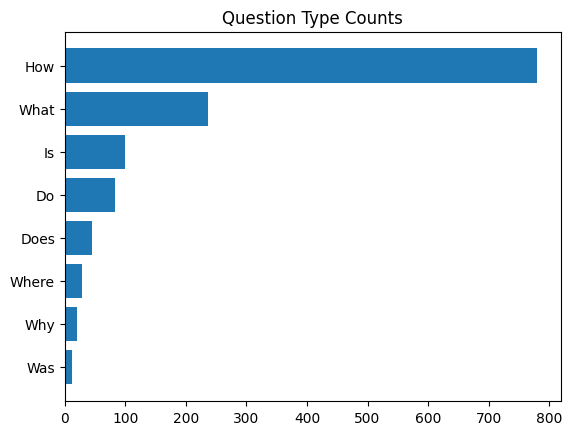

In [49]:
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

# Count the number of rows in dfs that started with question_types and save it in a dictionary
question_type_counts = {qt: len(dfs['train'][dfs['train']['question'].str.startswith(qt)]) for qt in question_types}
#sort question_type_counts by the number of rows into a dictionary
question_type_counts = {qt: count for qt, count in sorted(question_type_counts.items(), key=lambda x: x[1])}
# Plot a horizontal bar chart of the question type counts
import matplotlib.pyplot as plt
plt.title("Question Type Counts")
plt.barh(range(len(question_type_counts)), list(question_type_counts.values()), align='center')
plt.yticks(range(len(question_type_counts)), list(question_type_counts.keys()))
plt.show()


In [62]:
# Print random 3 questions of the dataframe dfs where the question starts with the word "What"
dfs['train'][dfs['train']['question'].str.startswith("What")].sample(3)["question"].values

array(['What is ear?',
       'What did you think of the soft focus ring being smooth and that it had enough range to fine tune the amount?',
       'What happend whit the sound?'], dtype=object)

In [63]:
# Print random 3 questions of the dataframe dfs where the question starts with the word "How"
dfs['train'][dfs['train']['question'].str.startswith("How")].sample(3)["question"].values


array(['How was unit ?', 'How much are the sharpness binoculars?',
       'How is the control?'], dtype=object)

In [64]:
# Print random 3 questions of the dataframe dfs where the question starts with the word "is"
dfs['train'][dfs['train']['question'].str.startswith("Is")].sample(3)["question"].values

array(['Is the color not really different?', 'Is there a product?',
       'Is a helpless camera?'], dtype=object)

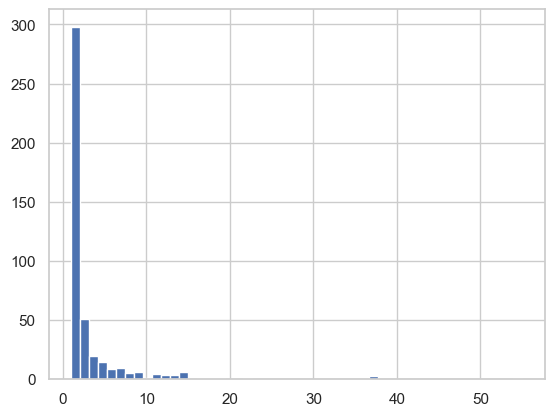

In [69]:
# Plot a histogram of the numbers of unique review_id for each title in dfs['train']
dfs['train']['title'].value_counts().hist(bins=50)
plt.show()

## Extracting the Answers from Context

The most common way to extract answers from text is by framing the problem as a span classification task,
where the start and end tokens of an answer span act as the labels that a model needs to predict. 


In [7]:
from transformers import AutoTokenizer

model_name = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [9]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [11]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_name)
outputs = model(**inputs)

In [13]:
start_scores, end_scores = outputs["start_logits"], outputs["end_logits"]

In [15]:
start_scores

tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]], grad_fn=<CopyBackwards>)

In [21]:
import torch
## Get the start and end index from the start_scores and end_scores
start_idx = torch.argmax(start_scores)
end_idx = torch.argmax(end_scores)

# Extract the span using the start_idx and end_idx from the inputs
span = tokenizer.decode(inputs["input_ids"][0][start_idx:end_idx+1])
print(f"Context: {context}")
print(f"Question: {question}")
print(f"Answer: {span}")

Context: An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.
Question: How much music can this hold?
Answer: 6000 hours
